In [4]:
import pandas as pd
import numpy as np
from tabulate import tabulate
from collections import namedtuple
from matplotlib import  pyplot as plt

In [6]:
data_path = 'https://www.ecdc.europa.eu/sites/default/files/documents/COVID-19-geographic-disbtribution-worldwide.xlsx'
df_ = pd.read_excel(data_path)
df_.head()

,dateRep,day,month,year,cases,deaths,countriesAndTerritories,geoId,countryterritoryCode,popData2019,continentExp,Cumulative_number_for_14_days_of_COVID-19_cases_per_100000
0,2020-12-14,14,12,2020,746,6,Afghanistan,AF,AFG,38041757.0,Asia,9.013779
1,2020-12-13,13,12,2020,298,9,Afghanistan,AF,AFG,38041757.0,Asia,7.052776
2,2020-12-12,12,12,2020,113,11,Afghanistan,AF,AFG,38041757.0,Asia,6.868768
3,2020-12-11,11,12,2020,63,10,Afghanistan,AF,AFG,38041757.0,Asia,7.134266
4,2020-12-10,10,12,2020,202,16,Afghanistan,AF,AFG,38041757.0,Asia,6.968658


In [7]:
df_.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61900 entries, 0 to 61899
Data columns (total 12 columns):
 #   Column                                                      Non-Null Count  Dtype         
---  ------                                                      --------------  -----         
 0   dateRep                                                     61900 non-null  datetime64[ns]
 1   day                                                         61900 non-null  int64         
 2   month                                                       61900 non-null  int64         
 3   year                                                        61900 non-null  int64         
 4   cases                                                       61900 non-null  int64         
 5   deaths                                                      61900 non-null  int64         
 6   countriesAndTerritories                                     61900 non-null  object        
 7   geoId                 

In [8]:
df = df_.drop(columns=['day', 'month', 'year', 'geoId', 'countryterritoryCode', 'continentExp'])
df = df.dropna()

In [9]:
countries = pd.unique(df['countriesAndTerritories'])
population = pd.unique(df['popData2019']).astype(np.int64)

# print(tabulate(pd.DataFrame({'Country': countries, 'Population': population}), headers='keys', tablefmt='psql'))
pd.DataFrame({'Country': countries, 'Population': population})

,Country,Population
0,Afghanistan,38041757
1,Albania,2862427
2,Algeria,43053054
3,Andorra,76177
4,Angola,31825299
...,...,...
207,Vietnam,96462108
208,Western_Sahara,582458
209,Yemen,29161922
210,Zambia,17861034


In [10]:
country_tuple = namedtuple('country_tuple', ['population', 'days', 'dates', 'cases', 'deaths', 
                                             'total_cases', 'total_deaths', 
                                             'total_cases_per1000', 'total_deaths_per1000', 'total_deaths2cases'])

def country_data(country, cut=0):
    sel_dates = df[df['countriesAndTerritories'] == country]['dateRep'].to_list()[::-1]
    sel_dates = [ts.strftime('%Y-%m-%d') for ts in sel_dates]
    sel_cases = df[df['countriesAndTerritories'] == country]['cases'].to_list()[::-1]
    sel_deaths = df[df['countriesAndTerritories'] == country]['deaths'].to_list()[::-1]
    total_cases = np.cumsum(sel_cases)
    total_deaths = np.cumsum(sel_deaths)
    cut_ix = 0
    for i, c in enumerate(total_cases):
        if c > cut:
            cut_ix = i
            break
    else:
        return None
    sel_dates = sel_dates[cut_ix:]
    sel_cases = sel_cases[cut_ix:]
    sel_deaths = sel_deaths[cut_ix:]
    total_cases = total_cases[cut_ix:]
    total_deaths = total_deaths[cut_ix:]

    people = population[countries == country][0]

    total_cases_per1000 = total_cases / people * 1000
    total_deaths_per1000 = total_deaths / people * 1000

    total_deaths2cases = total_deaths / total_cases

    return country_tuple(population=people, days=len(sel_dates),
                         dates=sel_dates, cases=np.array(sel_cases), deaths=np.array(sel_deaths),
                         total_cases=total_cases, total_deaths=total_deaths, 
                         total_cases_per1000=total_cases_per1000, total_deaths_per1000=total_deaths_per1000,
                         total_deaths2cases=total_deaths2cases)

In [11]:
def plot_countries(c_list, cut_cases=0, scale='linear'):
    cd_ = {c:country_data(c, cut=cut_cases) for c in c_list if c in countries}
    cd_ = {c:d for c, d in cd_.items() if d is not None}

    fig, (c_ax, d_ax) = plt.subplots(nrows=2, ncols=1, figsize=(18, 12))
    for key, val in cd_.items():
        c_ax.plot(val.total_cases_per1000, label=key)
    c_ax.legend()
    c_ax.set_yscale(scale)
    c_ax.grid(True)
    c_ax.title.set_text(f'Cases per 1000 population since {cut_cases} cases, by days')
    c_ax.title.set_color('white')
    c_ax.tick_params(axis='x', colors='white')
    c_ax.tick_params(axis='y', colors='white')

    for key, val in cd_.items():
        d_ax.plot(val.total_deaths2cases, label=key)
    d_ax.legend()
    d_ax.set_yscale(scale)
    d_ax.grid(True)
    d_ax.title.set_text(f'Deaths to cases ratio since {cut_cases} cases, by days')
    d_ax.title.set_color('white')
    d_ax.tick_params(axis='x', colors='white')
    d_ax.tick_params(axis='y', colors='white')

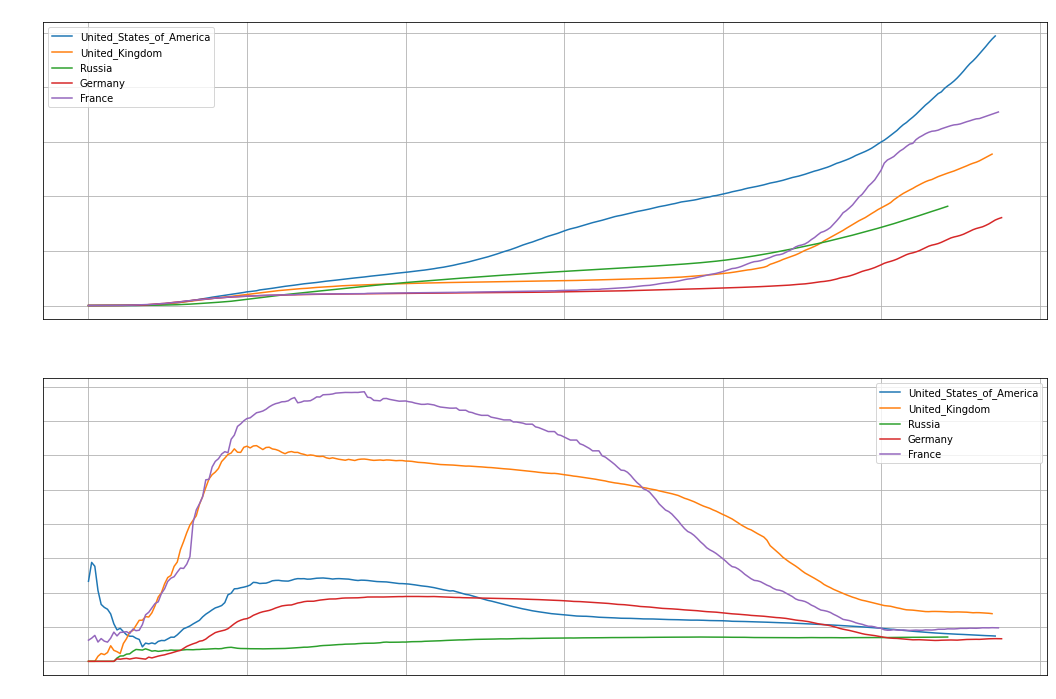

In [13]:
# countries_of_interest = ['United_States_of_America', 'South_Korea', 'Russia', 'United_Kingdom', 'Italy', 'China', 'Belarus', 'Japan']
countries_of_interest = ['United_States_of_America', 'United_Kingdom', 'Russia', 'Germany', 'France']
cut_cases = 100
plot_countries(countries_of_interest, cut_cases=cut_cases)#, scale='log')

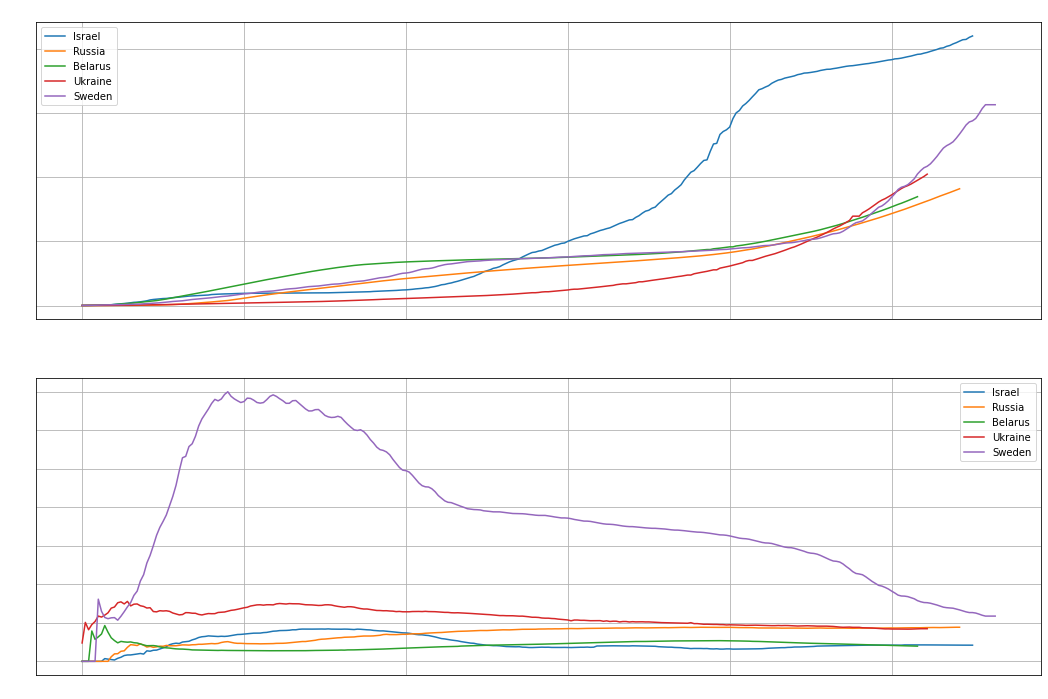

In [14]:
countries_of_interest = ['Israel', 'Russia', 'Belarus', 'Ukraine', 'Sweden']
cut_cases = 100
plot_countries(countries_of_interest, cut_cases=cut_cases)#, scale='log')

In [15]:
bel = country_data('Belarus')
bel.total_cases

array([     1,      1,      1,      1,      4,      6,      9,     12,
           21,     27,     36,     36,     46,     57,     57,     76,
           76,     81,     81,     86,     86,     94,     94,     94,
          105,    152,    152,    254,    351,    394,    564,    700,
          861,   1066,   1486,   1981,   2226,   2578,   2919,   3281,
         3728,   4204,   4779,   5297,   5807,   6264,   6723,   7281,
         8022,   8773,   9590,  10463,  11289,  12208,  13181,  14027,
        14917,  15828,  16705,  17489,  18350,  19255,  20168,  21101,
        22052,  22973,  23906,  24873,  25825,  26772,  27730,  28681,
        29650,  30572,  31508,  32426,  33371,  34303,  35244,  36198,
        37144,  38059,  38956,  39858,  40764,  41658,  42556,  43403,
        44255,  45116,  45981,  46868,  47751,  48630,  49453,  50265,
        51066,  51816,  52520,  53241,  53973,  54680,  55369,  56032,
        56657,  57333,  57936,  58505,  59023,  59487,  59945,  60382,
      

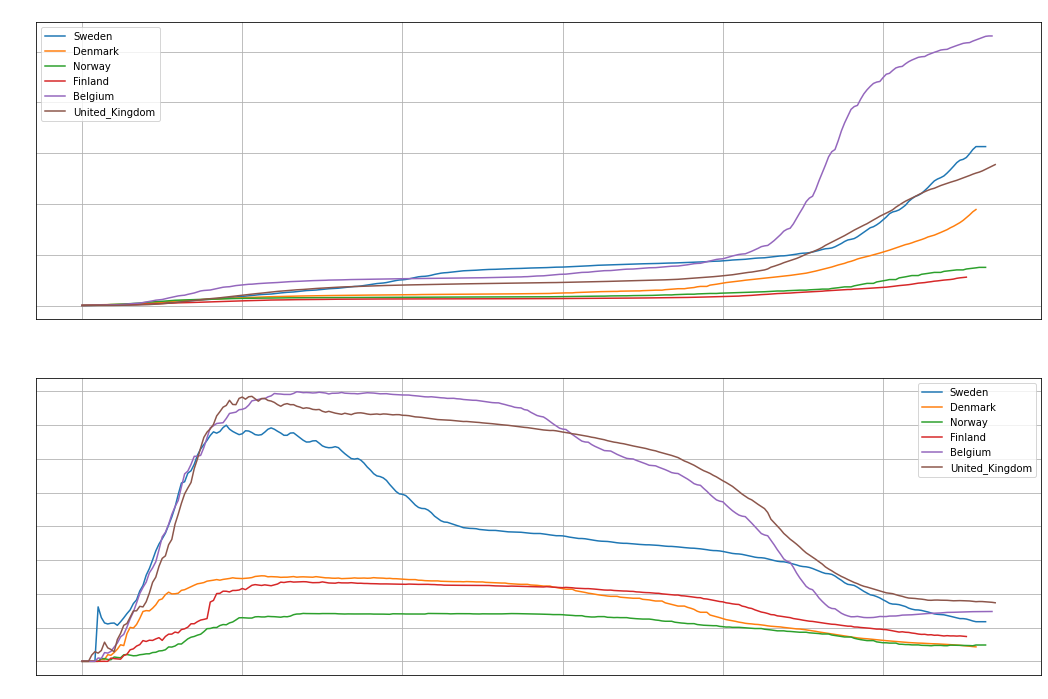

In [16]:
countries_of_interest = ['Sweden', 'Denmark', 'Norway', 'Finland', 'Belgium', 'United_Kingdom']
cut_cases = 100
plot_countries(countries_of_interest, cut_cases=cut_cases)

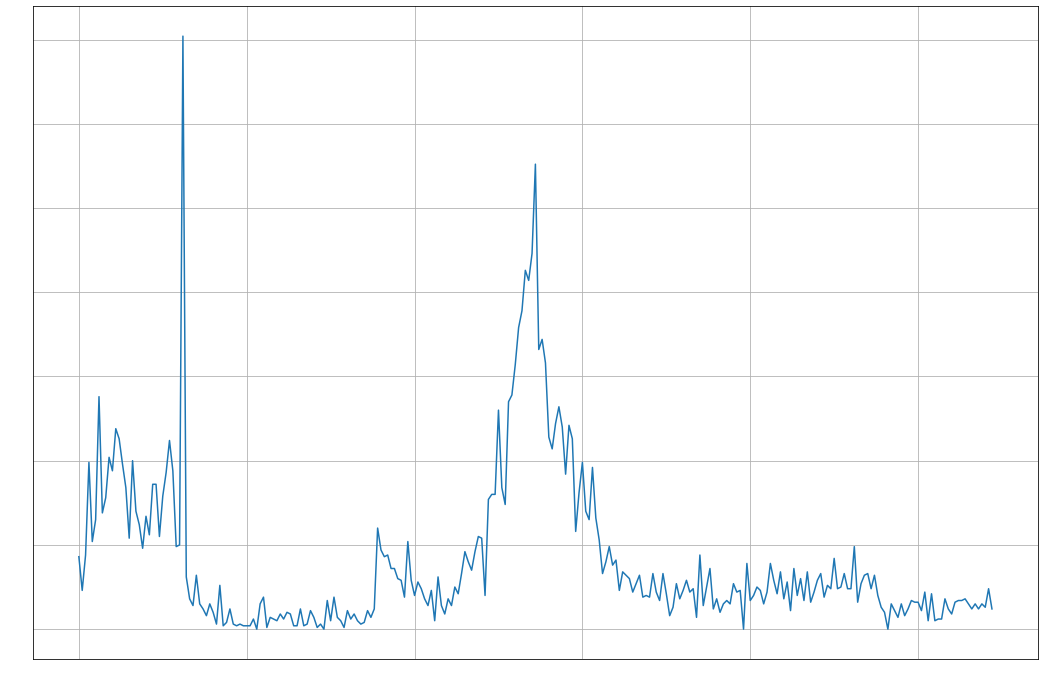

In [17]:
china = country_data('China')
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(18, 12))
ax.plot(china.cases[60:])
ax.set_yscale('linear')#og')
ax.grid(True)
ax.tick_params(axis='x', colors='white')
ax.tick_params(axis='y', colors='white')

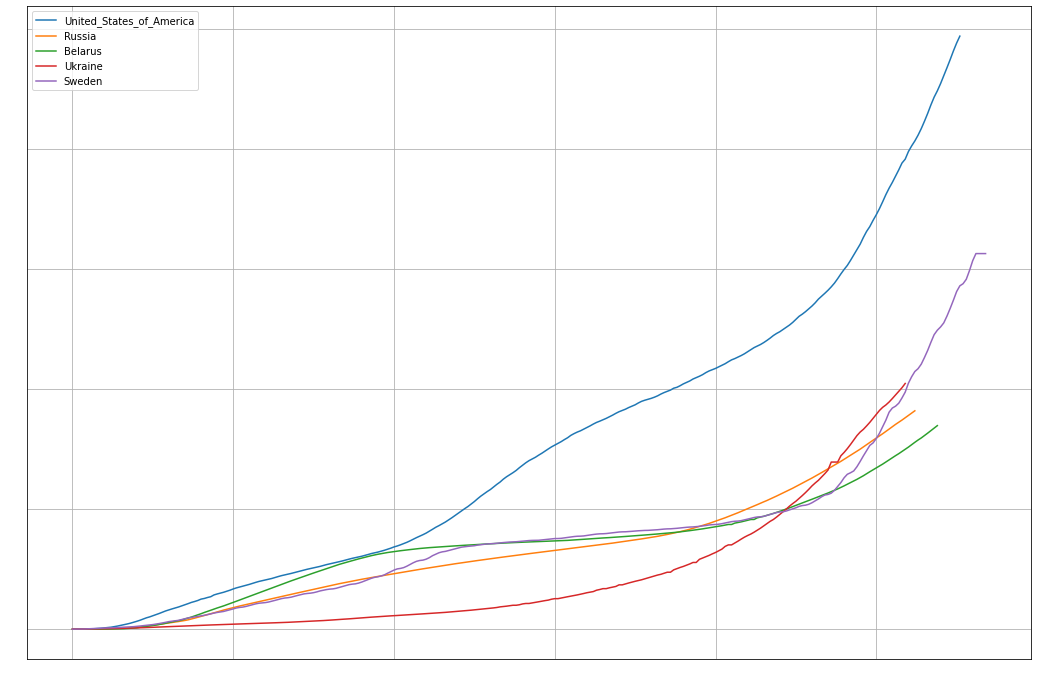

In [18]:
countries_of_interest = ['United_States_of_America', 'Russia', 'Belarus', 'Ukraine', 'Sweden']
data = {c:country_data(c) for c in countries_of_interest}
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(18, 12))
for d in data.keys():
    plot = sorted(list(filter(lambda x: x > 0.005, data[d].total_cases_per1000)))
    ax.plot(plot, label=d)
ax.grid(True)
ax.legend()
ax.tick_params(axis='x', colors='white')
ax.tick_params(axis='y', colors='white')

In [19]:
rus = country_data('Russia')
rus.total_cases

array([      2,       2,       2,       2,       2,       2,       2,
             2,       2,       2,       2,       2,       2,       2,
             2,       2,       2,       2,       2,       2,       2,
             2,       2,       2,       2,       2,       2,       2,
             2,       2,       2,       3,       4,       4,       4,
            10,      10,      10,      10,      10,      25,      30,
            45,      59,      63,      93,     114,     147,     199,
           253,     306,     367,     438,     495,     658,     840,
          1036,    1264,    1534,    1836,    2337,    2777,    3548,
          4149,    4731,    5389,    6343,    7497,    8672,   10131,
         11917,   13584,   15770,   18328,   21102,   24490,   27938,
         32008,   36793,   42853,   47121,   52763,   57999,   62773,
         68622,   74588,   80949,   87147,   93558,   99399,  106498,
        114431,  124054,  134687,  145268,  155370,  165929,  177160,
        187859,  198

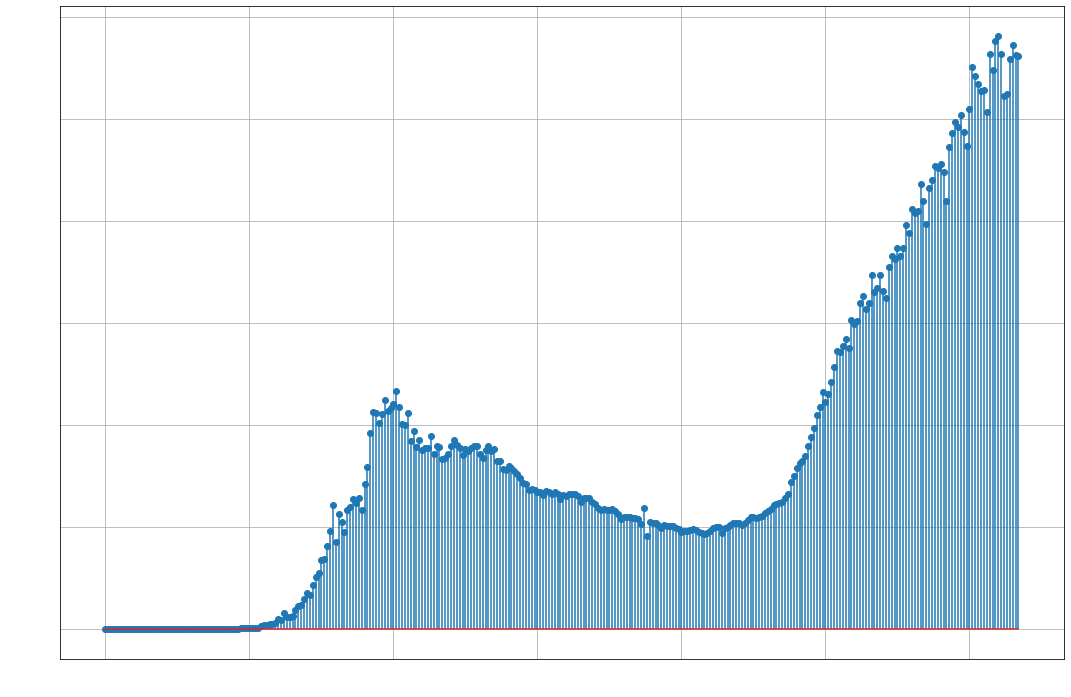

In [20]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(18, 12))
ax.stem(rus.cases, use_line_collection=True)
ax.grid(True)
ax.set_xlabel('Days', color='white')
ax.set_ylabel('Cases', color='white')
ax.tick_params(axis='x', colors='white')
ax.tick_params(axis='y', colors='white')
plt.show()

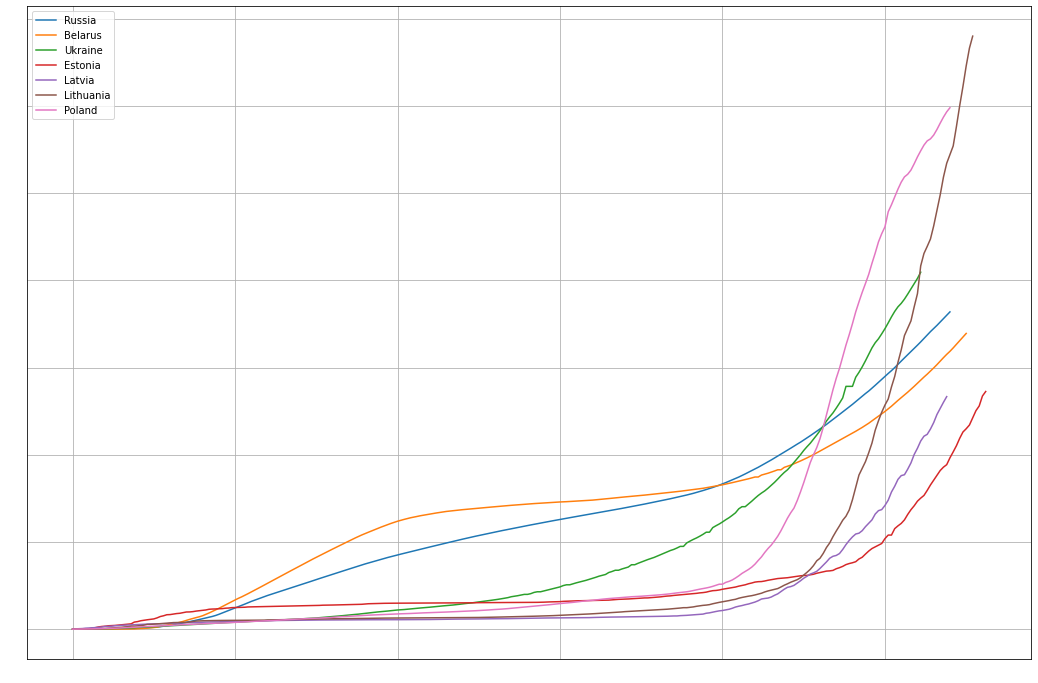

In [21]:
countries_of_interest = ['Russia', 'Belarus', 'Ukraine', 'Estonia', 'Latvia', 'Lithuania', 'Poland']
data = {c:country_data(c) for c in countries_of_interest}
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(18, 12))
for d in data.keys():
    plot = sorted(list(filter(lambda x: x > 0.001, data[d].total_cases_per1000)))
    ax.plot(plot, label=d)
ax.grid(True)
ax.legend()
ax.tick_params(axis='x', colors='white')
ax.tick_params(axis='y', colors='white')